<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [2]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [3]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-02 08:18:39--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.03s   

2022-02-02 08:18:40 (50.3 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2022-02-02 08:18:40--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [4]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [5]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [6]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [7]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [8]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words||
|Feature 1||
|Feature 2||
|Feature 3||

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [21]:
#######################
# MY HELPER FUNCTIONS #
#######################
'''
Reads a text file, and appends the words into a list
'''
def file_to_list(filename):

	my_file = open(filename, "r")
	content_list = my_file.readlines()
	i=0 
	while i < len(content_list):
		content_list[i] = content_list[i][:len(content_list[i])-1]
		i+=1
	return content_list

'''
Removes special chars except '-', for hyphens words like: 'eighteenth-century'
'''
def remove_special_chars(word):
	word_arr = []
	for ch in word:
		if ch == '-':
			word_arr.append(ch)
		elif 65 <= ord(ch) <= 90 or 97 <= ord(ch) <= 122:
				word_arr.append(ch)
	output = ''
	return output.join(word_arr)
 
''' 
Finds the top nth negative or positive terms,
and returns them as a list
'''
def top_terms(text, filedata, n=20):

  arr = file_to_list(filedata)
  tk_text = nltk.word_tokenize(text)
  top = []
  dic_freq = {}
  for i in arr:
    dic_freq[i] = 0
  
  # removing special chars from text
  for term in tk_text:
    term = remove_special_chars(term.lower())
  
  # building the dictionary frequency
  for word in tk_text:
    if word in dic_freq:
      dic_freq[word] +=1

  # sorting dictionary
  dic_freq = dict(sorted(dic_freq.items(), key=lambda item: item[1], reverse=True))
  
  # appending the top values
  for k,v in dic_freq.items():
    if len(top) == n:
      break
    else:
      top.append(k)

  return top

In [10]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    feats = {}
    for word in nltk.word_tokenize(text):
      word = remove_special_chars(word.lower())
      if word not in feats:
        feats[word] = 1
                        
    return feats

In [11]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 20326, Train accuracy: 1.000, Dev accuracy: 0.765


For feature1, I am looking for positive words from a large list. I found the list here: https://gist.github.com/mkulakowski2/4289437

1. I read the file 'positive.txt' and store the words into a list

2. I tokenize the text, and I also made my own helper function called "remove_special_chars" to remove punctuation, so that "Terrible!" -> "terrible"

3. I parse the tokenized text "tk_text" and see if there is any positive term. If there is, I add 1 to the dictionary "feats".

Additionally, I am trying to handle two edge scenarios: 

(i) i.e."did not like", or "did not love". In this case, the counting of positive terms, shouldn't go up. 

(ii) "it was good, but...", in this scenario, my tokenized text "tk_text" will be 'it','was','good','but'; therefore, if after a positive word, there is 'but', it shouldn't count


In conclusion, I believe this feature is valid because it searches for positive terms, and these positive terms come from a large list.

In [12]:
# POSITIVE [check if it's preceded by "not"]
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    feats = {'has_positive': 0}
    positive_arr = file_to_list('positive.txt')
    tk_text = nltk.word_tokenize(text)

    for word in tk_text:
      word = remove_special_chars(word.lower())

    i=0
    while i < len(tk_text):
      if remove_special_chars(tk_text[i].lower()) in positive_arr:
        if remove_special_chars(tk_text[i-1].lower()) != 'not':
          if i == len(tk_text) - 1:
            feats['has_positive'] += 1
          else:
            if remove_special_chars(tk_text[i+1].lower()) != 'but' or remove_special_chars(tk_text[i+1].lower()) != 'except':
              feats['has_positive'] += 1
      i+=1

    return feats


In [13]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 1, Train accuracy: 0.602, Dev accuracy: 0.622


For feature2, I am looking for negative terms. I applied the same logic as in feature1. 
I found the list here: https://gist.github.com/mkulakowski2/4289441

Similarly to feature1, I believe feature2 is valid too because it searches for negative terms, and these negative terms come from a large list. 

In [14]:
# NEGATIVE
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {'has_negative': 0}
    negative_arr = file_to_list('negative.txt')
    tk_text = nltk.word_tokenize(text)

    for word in tk_text:
      word = remove_special_chars(word.lower())

    i=0
    while i < len(tk_text):
      if remove_special_chars(tk_text[i].lower()) in negative_arr:
        if remove_special_chars(tk_text[i-1].lower()) != 'not':
          if i == len(tk_text) - 1:
            feats['has_negative'] += 1
          else:
            if remove_special_chars(tk_text[i+1].lower()) != 'but' or remove_special_chars(tk_text[i+1].lower()) != 'except':
              feats['has_negative'] += 1
      i+=1

    return feats

In [15]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 1, Train accuracy: 0.599, Dev accuracy: 0.576


For feature3, the main difference is that I'm first running my helper function called "top_terms" to collect the top negative terms. You can find "top_terms" along with my other helper functions in the cell that is before "bag_of_words"

"top_terms()" works this way:

1. For every negative/positive term, it initializes a frequency dictionary like this {term: 0, term2: 0, etc...}  
2. For every word in "text", if it matches any key in the dictionary, its count will increase
3. I'm sorting the dictionary, and returning the top nth terms as a list (by default the function returns the top 20).

The rest of the logic is identical to features1-2. Overall, I believe this is a valid feature because rather than simply taking a large list of positive/negative terms, I'm first seeing which ones appear more frequently in the text, and from that, I create my dataset from where I take my positive/negative words that I compare with each review.

In [19]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    feats = {'has_negative': 0}
    negative_arr = top_terms(text, 'negative.txt')
    tk_text = nltk.word_tokenize(text)
    for word in tk_text:
      word = remove_special_chars(word.lower())

    i=0
    while i < len(tk_text):
      if remove_special_chars(tk_text[i].lower()) in negative_arr:
        if remove_special_chars(tk_text[i-1].lower()) != 'not':
          if i == len(tk_text) - 1:
            feats['has_negative'] += 1
          else:
            if remove_special_chars(tk_text[i+1].lower()) != 'but' or remove_special_chars(tk_text[i+1].lower()) != 'except':
              feats['has_negative'] += 1
      i+=1

    return feats

In [22]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 1, Train accuracy: 0.606, Dev accuracy: 0.589


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [23]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [24]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 20328, Train accuracy: 1.000, Dev accuracy: 0.783


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


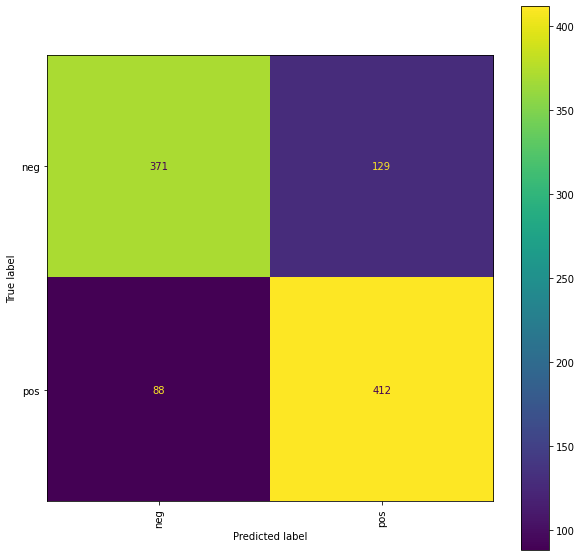

In [25]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [26]:
big_classifier.printWeights(n=25)

pos	0.748	very
pos	0.606	great
pos	0.562	excellent
pos	0.531	seen
pos	0.525	top
pos	0.510	enjoyed
pos	0.498	violence
pos	0.493	saw
pos	0.487	simple
pos	0.479	relationship
pos	0.468	thought
pos	0.466	back
pos	0.463	away
pos	0.452	friends
pos	0.446	new
pos	0.431	man
pos	0.430	definitely
pos	0.414	amazing
pos	0.407	true
pos	0.404	performance
pos	0.399	you
pos	0.393	series
pos	0.387	in
pos	0.386	him
pos	0.386	perfect

neg	-0.856	worst
neg	-0.816	acting
neg	-0.720	actors
neg	-0.666	watching
neg	-0.663	idea
neg	-0.634	would
neg	-0.616	boring
neg	-0.594	nothing
neg	-0.549	were
neg	-0.544	script
neg	-0.523	there
neg	-0.497	stupid
neg	-0.496	maybe
neg	-0.483	least
neg	-0.483	instead
neg	-0.481	money
neg	-0.478	can
neg	-0.468	could
neg	-0.457	work
neg	-0.452	said
neg	-0.446	waste
neg	-0.445	silly
neg	-0.439	enough
neg	-0.436	something
neg	-0.424	even



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [27]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [28]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,0.999968,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1822,0.999955,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to Fulci's hit Zombi 2, with Zombi 2 itself being of course a marketing ploy to trick people into thinking it was a sequel to George A. Romero's Dawn of the Dead aka Zombi. Confusing enough? Basically, none of the films have anything to do with one another, but who cares when they make money. I guess Fulci himself start..."
2,1551,0.999937,neg,pos,"I firmly believe that the best Oscar ceremony in recent years was in 2003 for two reasons: 1 ) Host Steve Martin was at his most wittiest: "" I saw the teamsters help Michael Moore into the trunk of his limo "" and "" I'll better not mention the gay mafia in case I wake up with a poodle's head in my bed "" 2 ) Surprise winners: No one had Adrien Brody down for best actor ( Genuine applause ) or Ro..."
3,1004,0.999767,neg,pos,"Certainly NOMAD has some of the best horse riding scenes, swordplay, and scrumptious landscape cinematography you'll likely see, but this isn't what makes a film good. It helps but the story has to shine through on top of these things. And that's where Nomad wanders.The story is stilted, giving it a sense that it was thrown together simply to make a ""cool"" movie that ""looks"" great. Not to ment..."
4,1247,0.999273,neg,pos,"Let's start by the simple lines. From the viewer's side, there a couple of good ""director details"", some points of view at the movie scenes that are nice. The special effects are good enough, a good acting/good scenery also. But the story is way too simple. It shows how a elite Army bomb squad unit lives, acts and sometimes dies. It shows the drama of living in war. In my movie experience as a..."
5,1035,0.999022,neg,pos,"Emma is my favourite Jane Austen novel - Emma is well-meaning despite her flaws, so readers can forgive and love her, and the relationship she has with Mr Knightley, which is warm, familiar, respectful but playful, generating that warm, fuzzy, romantic excitement. Mr Knightley is the perfect man, and Emma is as close as you could get in those times to an independent, clever, confident woman - ..."
6,1659,0.998469,pos,neg,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry fo..."
7,1677,0.998281,neg,pos,"Hello. this is my first review for any movie i have seen. i went through the trouble of doing this to tell everyone that this is quite literally, the most disgusting movie i have ever seen. I feel like the movie was porely made, which i will give some understanding due to budget constraints on making it. I felt like i was watching a very bad remake of the movie saw. Which i can agree, saw as w..."
8,1833,0.998062,neg,pos,"This was yet another big screen outing for a US TV show from the sixties It is amusing enough but was very much to formula. Intelligent Martian lands on Earth and meets the not too bright humans, in his view.The usual wackiness ensues with the human, Bridges, eventually bonds with him and helps him to get home. Along the way he also gets the girl, Hannah.This is a nice outing for some pleasant..."
9,1576,0.997976,neg,pos,"Billy Chung Siu Hung's (the bloody swordplay film Assassin from 1993) f